In [240]:
from typing import List
import numpy as np
import pathlib
import bs4 as bs
import re
import os
import pytest 
import glob
import pandas as pd
import chardet
from chardet.universaldetector import UniversalDetector

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

dataset_folder = 'data'
detector = UniversalDetector()

In [ ]:


authorIDs = [3574878, 2845196, 3444474, 3445677, 828046, 4284264, 3498812, 4137740, 3662461, 3363271]
filenames = []



for id in authorIDs:
 filename = glob.glob('blogs/' + str(id) + '.*.xml')
 filenames.append(filename[0])
    
for filename in filenames:
#for filename in glob.glob('blogs/*.xml'):
    print(filename)
    detector.reset()
    for line in open(filename, 'rb'):
        detector.feed(line)
        if detector.done: break
    detector.close()
    print(detector.result['encoding'])

In [226]:
class Post:
    author_number: int
    gender: str
    age: int
    industry: str
    star_sign: str
    date: str  
    post: str

    def to_dict(self):
        return {
            key: getattr(self, key)
            for key in ['author_number', 'gender', 'age', 'industry', 'star_sign', 'date', 'post']
        }

    @staticmethod
    def load_from_file(filename) -> List["Post"]:
        # The last element is the file extension, which we don't care about
        # example file format is: 5144.male.25.indUnk.Scorpio.xml
        age, author_number, gender, industry, star_sign = Post.extract_attributes_from_filename(filename)

        posts = []
        
        encoding = Post.get_encoding(filename);
        xml_source = open(filename, errors='surrogateescape', encoding=encoding).read()
        #xml_source = open(filename, errors='strict', encoding=encoding).read()
        #xml_source = open(filename, errors='replace').read()
        xml_soup = bs.BeautifulSoup(xml_source, "lxml")
        xml_posts = xml_soup.find_all("post")
        xml_dates = xml_soup.find_all("date")
        #print(posts[0].text)
        
        for i in range(0, len(xml_posts)):
            new_post = Post.create_from_attributes(
                author_number, gender, age, industry, star_sign, xml_dates[i].text.strip(), xml_posts[i].text.strip())
            posts.append(new_post)

        return posts

    @staticmethod
    def extract_attributes_from_filename(filename):
        base_filename = pathlib.Path(filename).name  # Get just the filename component
        author_number, gender, age, industry, star_sign, _ = base_filename.split(".")
        author_number = int(author_number)
        age = int(age)
        return age, author_number, gender, industry, star_sign

    @staticmethod
    def get_encoding(filename):
        detector.reset()
        for line in open(filename, 'rb'):
            detector.feed(line)
            if detector.done: break
        detector.close()
        return detector.result['encoding']
    
    @staticmethod
    def create_from_attributes(author_number, gender, age, industry, star_sign, date, post):
        p = Post()
        p.author_number = author_number
        p.gender = gender
        p.age = age
        p.industry = industry
        p.star_sign = star_sign
        p.date = date  
        p.post = post  
        return p

In [227]:
p = Post.load_from_file('data\\3363271.female.27.Student.Virgo.xml')
e = Post.extract_attributes_from_filename('data\\3363271.female.27.Student.Virgo.xml')
c = Post.get_encoding('data\\4137740.female.47.indUnk.Libra.xml')
p = Post.load_from_file('data\\4137740.female.47.indUnk.Libra.xml')
print(p[0].post)
#print(e)
print(c)

Well... I am unsure how to start this new blogging stuff...guess I will just reflect a little and see how it goes.  Have you ever been stuck in a matrix? I have! To me it was like being in a padded, suspended time warp during the early part of  my adult life. A time that lasted over 12 years. That shouldn’t happen to anyone...and shouldn’t have happen to me. But it did. I was 23 , a new single mom...no friends...no job...and not much family to speak of. I had to make money and take care of my son... I couldn’t afford to live on my own so me and my child stayed with my parents... I went back to school and learned a vocation. Then... tried for years and years to make a difference...be somebody and amount to something for my sons sake...the matrix I was in got thicker and harder to escape from...I couldn’t do enough for anyone. My parents, my employer, so called friends, relatives.... it was like total non-acceptance...I felt laughed at and demeaned.  (Like a RedHeaded Step Child.)  I had

In [228]:
filename_id_pattern = re.compile(r"(\d{3,})\..*\..*\..*\..*\.xml")

def get_filename_id(filename):
    # We use search, not match, as we don't care if it's not the whole string
    match = filename_id_pattern.search(filename)
    if match:
        return match.group(1)
    else:
        raise ValueError(f"Could not find an ID in filename {filename}")
        
def get_all_xml_files_in_folder(dataset_folder):
    return glob.glob(os.path.join(dataset_folder, "*.xml"))

def load_dataset_from_raw(dataset_folder):
    all_posts = []
    #print(get_all_xml_files_in_folder(dataset_folder))
    for filename in get_all_xml_files_in_folder(dataset_folder):
        current_posts = Post.load_from_file(filename)
        all_posts.extend(current_posts)
    return all_posts



In [229]:
def save_dataset(all_posts, output_file):
    dataset = pd.DataFrame([post.to_dict() for post in all_posts])
    dataset.to_parquet(output_file, compression='gzip')
    return dataset


def load_dataset(input_file):
    return pd.read_parquet(input_file)

In [230]:
raw_dataset = load_dataset_from_raw(dataset_folder)
save_dataset(raw_dataset, 'posts1.data')
#processed_dataset = load_dataset(filename)


,author_number,gender,age,industry,star_sign,date,post
0,1000331,female,37,indUnk,Leo,"31,May,2004","Well, everyone got up and going this morning. ..."
1,1000331,female,37,indUnk,Leo,"29,May,2004",My four-year old never stops talking. She'll ...
2,1000331,female,37,indUnk,Leo,"28,May,2004","Actually it's not raining yet, but I bought 15..."
3,1000331,female,37,indUnk,Leo,"28,May,2004",Ha! Just set up my RSS feed - that is so easy!...
4,1000331,female,37,indUnk,Leo,"28,May,2004","Oh, which just reminded me, we were talking ab..."
...,...,...,...,...,...,...,...
681248,999503,male,25,Internet,Cancer,"04,July,2004",Today we celebrate our independence day. In...
681249,999503,male,25,Internet,Cancer,"03,July,2004","Ugh, I think I have allergies... My nose has ..."
681250,999503,male,25,Internet,Cancer,"02,July,2004","""Science is like sex; occasionally something p..."
681251,999503,male,25,Internet,Cancer,"01,July,2004",urlLink Dog toy or marital aid I managed 10/...


In [231]:
dataset_filename = "posts1.data"
all_posts = load_dataset(dataset_filename)

all_posts.head() 

,author_number,gender,age,industry,star_sign,date,post
0,1000331,female,37,indUnk,Leo,"31,May,2004","Well, everyone got up and going this morning. ..."
1,1000331,female,37,indUnk,Leo,"29,May,2004",My four-year old never stops talking. She'll ...
2,1000331,female,37,indUnk,Leo,"28,May,2004","Actually it's not raining yet, but I bought 15..."
3,1000331,female,37,indUnk,Leo,"28,May,2004",Ha! Just set up my RSS feed - that is so easy!...
4,1000331,female,37,indUnk,Leo,"28,May,2004","Oh, which just reminded me, we were talking ab..."


In [198]:
#example_authors = [3574878, 2845196, 3444474, 3445677, 828046, 4284264, 3498812, 4137740, 3662461, 3363271]
example_authors = [828046, 4137740, 3662461 ]

def get_sampled_authors(dataset, sample_authors):
    mask = dataset['author_number'].isin(sample_authors)
    return dataset[mask]


sample = get_sampled_authors(all_posts, example_authors)
    

documents = sample['post'].values
authors = sample['author_number'].values
print(authors) #19 authors

[3662461 3662461 3662461 3662461 3662461 4137740 4137740  828046  828046
  828046  828046  828046  828046  828046  828046  828046  828046  828046
  828046]


In [199]:
from sklearn.model_selection import train_test_split
documents_train, documents_test, authors_train, authors_test = train_test_split(documents, authors)

len(documents_train), len(documents_test), len(authors_train), len(authors_test)



(14, 5, 14, 5)

In [255]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

#preprocessor = TfidfVectorizer(analyzer='char', ngram_range=(2,3))
preprocessor = TfidfVectorizer(analyzer='word')
X_train = preprocessor.fit_transform(documents_train)
print(X_train.shape)
X_test = preprocessor.transform(documents_test)
print(X_test.shape)

models = [ SGDClassifier(), SVC(kernel='rbf'), SVC(kernel='linear'), BernoulliNB()]
for model in models:
    print(model)
    model.fit(X_train, authors_train)
    authors_predicted = model.predict(X_test)

    print(authors_test)
    print(authors_predicted)
    print(classification_report(authors_test, authors_predicted))


(14, 374)
(5, 374)
SGDClassifier()
[3662461 3662461 4137740  828046  828046]
[3662461  828046  828046  828046  828046]
              precision    recall  f1-score   support

      828046       0.50      1.00      0.67         2
     3662461       1.00      0.50      0.67         2
     4137740       0.00      0.00      0.00         1

    accuracy                           0.60         5
   macro avg       0.50      0.50      0.44         5
weighted avg       0.60      0.60      0.53         5

SVC()
[3662461 3662461 4137740  828046  828046]
[828046 828046 828046 828046 828046]
              precision    recall  f1-score   support

      828046       0.40      1.00      0.57         2
     3662461       0.00      0.00      0.00         2
     4137740       0.00      0.00      0.00         1

    accuracy                           0.40         5
   macro avg       0.13      0.33      0.19         5
weighted avg       0.16      0.40      0.23         5

SVC(kernel='linear')
[3662461 3662

C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\

In [201]:
feature_names = preprocessor.get_feature_names()
print(len(feature_names))
dense = X_train.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)


374


In [202]:
print(df[0:100])

          20      2074        60       70s  ability  accessories   achieve  \
0   0.000000  0.000000  0.081919  0.000000  0.00000     0.000000  0.000000   
1   0.000000  0.000000  0.000000  0.000000  0.00000     0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.194517  0.00000     0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.00000     0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.00000     0.000000  0.000000   
5   0.239248  0.239248  0.000000  0.000000  0.00000     0.000000  0.000000   
6   0.000000  0.000000  0.000000  0.000000  0.00000     0.153067  0.153067   
7   0.000000  0.000000  0.000000  0.000000  0.00000     0.000000  0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.00000     0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.00000     0.000000  0.000000   
10  0.000000  0.000000  0.000000  0.000000  0.00000     0.000000  0.000000   
11  0.000000  0.000000  0.000000  0.000000  0.06367     0.000000

In [280]:
sample_authors = np.random.choice(all_posts['author_number'].unique(), 10)

In [277]:

def build_pipeline():
    parameters = [
        #{'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear']},
        #{'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.001, 0.0001], 'svc__kernel': ['rbf']},
        {'sgdclassifier__penalty': ['elasticnet'], 
         'sgdclassifier__alpha': [10 ** x for x in range(-6, 1)], 
         'sgdclassifier__l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1], 
         'sgdclassifier__loss': ['log']}
    ]
    
    model = make_pipeline(TfidfVectorizer(analyzer='char', ngram_range=(2,3)), 
                          SGDClassifier(alpha=1e-06, l1_ratio=0.2, loss='log', penalty='elasticnet'))
    gs = GridSearchCV(model, parameters)
    return gs

def run_analysis(num_authors, model):
    sample = get_sampled_authors(all_posts, sample_authors)
    documents = sample['post']
    authors = sample['author_number']
    documents_train, documents_test, authors_train, authors_test = train_test_split(documents, authors)
    model.fit(documents_train, authors_train)
    authors_predicted = model.predict(documents_test)
    print(classification_report(authors_test, authors_predicted))
    return f1_score(y_pred=authors_predicted, y_true=authors_test, average='macro')

model = build_pipeline()
score = run_analysis(10, model)

print(score)
print(model.best_score_)                              
print(model.best_estimator_)

C:\Users\luke\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

     1870925       0.79      1.00      0.88        15
     2576804       0.75      1.00      0.86         3
     3465409       0.00      0.00      0.00         1
     3466074       0.00      0.00      0.00         0
     3614091       1.00      0.50      0.67         6
     3916402       1.00      1.00      1.00         1
     3990797       0.00      0.00      0.00         2
     4246486       0.00      0.00      0.00         1

    accuracy                           0.76        29
   macro avg       0.44      0.44      0.43        29
weighted avg       0.73      0.76      0.72        29

0.4257703081232493
0.8163398692810457
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(2, 3))),
                ('sgdclassifier',
                 SGDClassifier(alpha=1e-06, l1_ratio=0.2, loss='log',
                               penalty='elasticnet'))])


C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_types = [SGDClassifier(), SVC(kernel='rbf'), SVC(kernel='linear'), BernoulliNB()]
    



In [282]:

def build_pipeline():
    parameters = [
        {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear']},
        {'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.001, 0.0001], 'svc__kernel': ['rbf']} 
    ]
    
    model = make_pipeline(TfidfVectorizer(analyzer='char', ngram_range=(2,3)), SVC(C=10, kernel='linear'))
    gs = GridSearchCV(model, parameters)
    return gs

def run_analysis(num_authors, model):
    sample = get_sampled_authors(all_posts, sample_authors)
    documents = sample['post']
    authors = sample['author_number']
    documents_train, documents_test, authors_train, authors_test = train_test_split(documents, authors)
    model.fit(documents_train, authors_train)
    authors_predicted = model.predict(documents_test)
    print(classification_report(authors_test, authors_predicted))
    return f1_score(y_pred=authors_predicted, y_true=authors_test, average='macro')

model = build_pipeline()
score = run_analysis(10, model)

print(score)
print(model.best_score_)                              
print(model.best_estimator_)

C:\Users\luke\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

     1316855       0.93      1.00      0.96       202
     2950030       1.00      1.00      1.00        10
     3157667       1.00      0.67      0.80         6
     3337576       0.00      0.00      0.00         2
     3636538       0.89      0.73      0.80        11
     3693865       1.00      0.20      0.33         5
     3747276       0.00      0.00      0.00         1
     3976948       0.00      0.00      0.00         2
     4161215       0.00      0.00      0.00         1
     4213143       0.00      0.00      0.00         1

    accuracy                           0.93       241
   macro avg       0.48      0.36      0.39       241
weighted avg       0.90      0.93      0.91       241

0.38927605409705646
0.9362068965517241
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(2, 3))),
                ('svc', SVC(C=100, kernel='linear'))])


C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
precision    recall  f1-score   support

     2416268       0.96      0.74      0.84        31
     2615621       0.82      0.97      0.89        37
     3325749       1.00      1.00      1.00        13
     3338542       1.00      1.00      1.00         2
     3499978       0.79      0.75      0.77        20
     3581717       1.00      1.00      1.00         7
     3654359       0.00      0.00      0.00         2
     3919118       0.00      0.00      0.00         0
     4298893       0.00      0.00      0.00         4

    accuracy                           0.83       116
   macro avg       0.62      0.61      0.61       116
weighted avg       0.84      0.83      0.83       116

0.6104981438314772
0.8934575569358179

C:\Users\luke\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

     1316855       0.95      1.00      0.97       205
     2950030       1.00      1.00      1.00        10
     3157667       1.00      1.00      1.00         3
     3337576       0.00      0.00      0.00         2
     3636538       0.82      0.69      0.75        13
     3693865       1.00      0.20      0.33         5
     3976948       1.00      1.00      1.00         1
     4161215       0.00      0.00      0.00         1
     4213143       0.00      0.00      0.00         1

    accuracy                           0.95       241
   macro avg       0.64      0.54      0.56       241
weighted avg       0.93      0.95      0.93       241



C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

     1316855       0.93      1.00      0.96       207
     2950030       1.00      0.92      0.96        12
     3157667       1.00      0.60      0.75         5
     3636538       0.50      0.12      0.20         8
     3693865       1.00      0.40      0.57         5
     3747276       0.00      0.00      0.00         1
     3976948       0.00      0.00      0.00         2
     4161215       0.00      0.00      0.00         1

    accuracy                           0.93       241
   macro avg       0.55      0.38      0.43       241
weighted avg       0.91      0.93      0.91       241



C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

     1316855       0.94      1.00      0.97       207
     2950030       1.00      0.91      0.95        11
     3157667       1.00      0.50      0.67         4
     3337576       0.00      0.00      0.00         2
     3636538       1.00      0.64      0.78        11
     3693865       1.00      1.00      1.00         2
     3976948       0.00      0.00      0.00         1
     4161215       0.00      0.00      0.00         2
     4213143       0.00      0.00      0.00         1

    accuracy                           0.95       241
   macro avg       0.55      0.45      0.49       241
weighted avg       0.92      0.95      0.93       241



C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

     1316855       0.94      1.00      0.97       211
     2950030       1.00      1.00      1.00         8
     3157667       1.00      0.75      0.86         4
     3636538       0.75      0.43      0.55         7
     3693865       1.00      0.14      0.25         7
     3976948       0.00      0.00      0.00         2
     4161215       0.00      0.00      0.00         2

    accuracy                           0.94       241
   macro avg       0.67      0.47      0.52       241
weighted avg       0.92      0.94      0.92       241



C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

     1316855       0.95      1.00      0.97       207
     2950030       1.00      1.00      1.00        10
     3157667       1.00      0.75      0.86         4
     3337576       0.00      0.00      0.00         1
     3636538       0.75      0.75      0.75         8
     3693865       1.00      0.11      0.20         9
     3976948       0.00      0.00      0.00         2

    accuracy                           0.94       241
   macro avg       0.67      0.52      0.54       241
weighted avg       0.93      0.94      0.92       241



C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

     1316855       0.94      0.99      0.96       209
     2950030       1.00      1.00      1.00        10
     3157667       1.00      0.67      0.80         3
     3636538       0.83      0.62      0.71         8
     3693865       0.50      0.17      0.25         6
     3976948       0.00      0.00      0.00         2
     4161215       0.00      0.00      0.00         3

    accuracy                           0.93       241
   macro avg       0.61      0.49      0.53       241
weighted avg       0.91      0.93      0.92       241



C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

     1316855       0.96      1.00      0.98       216
     2950030       1.00      1.00      1.00         8
     3157667       1.00      1.00      1.00         2
     3636538       0.71      0.62      0.67         8
     3693865       1.00      0.50      0.67         2
     3747276       0.00      0.00      0.00         1
     3976948       0.00      0.00      0.00         2
     4161215       0.00      0.00      0.00         1
     4213143       0.00      0.00      0.00         1

    accuracy                           0.96       241
   macro avg       0.52      0.46      0.48       241
weighted avg       0.94      0.96      0.95       241



C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

     1316855       0.95      0.99      0.97       202
     2950030       1.00      1.00      1.00        17
     3157667       1.00      0.75      0.86         4
     3636538       0.86      0.67      0.75         9
     3693865       0.67      0.40      0.50         5
     3976948       0.00      0.00      0.00         1
     4161215       0.00      0.00      0.00         1
     4213143       0.00      0.00      0.00         2

    accuracy                           0.95       241
   macro avg       0.56      0.48      0.51       241
weighted avg       0.93      0.95      0.93       241



C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luke\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

     1316855       0.93      1.00      0.96       208
     2950030       1.00      1.00      1.00         8
     3157667       1.00      0.40      0.57         5
     3337576       0.00      0.00      0.00         1
     3636538       0.71      0.50      0.59        10
     3693865       1.00      0.14      0.25         7
     3976948       0.00      0.00      0.00         2

    accuracy                           0.93       241
   macro avg       0.66      0.43      0.48       241
weighted avg       0.91      0.93      0.91       241



C:\Users\luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     1316855       0.93      1.00      0.96       201
     2950030       1.00      1.00      1.00        12
     3157667       1.00      1.00      1.00         2
     3337576       0.00      0.00      0.00         1
     3636538       0.80      0.57      0.67        14
     3693865       1.00      0.50      0.67         4
     3976948       0.00      0.00      0.00         3
     4161215       0.00      0.00      0.00         3
     4213143       0.00      0.00      0.00         1

    accuracy                           0.93       241
   macro avg       0.53      0.45      0.48       241
weighted avg       0.90      0.93      0.91       241



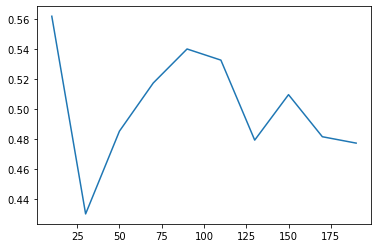

In [283]:
scores = np.array([
    [n_authors, run_analysis(n_authors, model)]
    for n_authors in np.arange(10, 200, 20)
])

from matplotlib import pyplot as plt

plt.plot(*scores.T)